In [1]:
# Lab | Making predictions with logistic regression
# In this lab, you will be using the Sakila database of movie rentals.

# In order to optimize our inventory, we would like to know which films 
#will be rented next month and we are asked to create a model to predict it.

# Instructions
# 1 Create a query or queries to extract the information you think may be relevant for building the prediction model.
# It should include some film features and some rental features. Use the data from 2005.

# 2 Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). 
# This would be our target variable.

# 3 Read the data into a Pandas dataframe.

# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

# 5 Create a logistic regression model to predict this variable from the cleaned data.

# 6 Evaluate the results.


In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
# This code is written in Python and uses the SQLAlchemy library and the Pandas library to extract data from a MySQL database.
# "connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'" - This line creates a connection string for the MySQL database. The connection string specifies the database type, user name ('root'), password, host (localhost), and database name ('sakila').
# "engine = create_engine(connection_string)" - This line creates an SQLAlchemy engine using the connection string. The engine is used to connect to the database and execute SQL statements.
# "query = '''SELECT f.title AS 'film_title', COUNT(r.rental_date)..." - This line defines an SQL query to extract data from the 'sakila' database. The query selects the title of a film and the number of times it was rented in August 2005. The result is grouped by film title and ordered by film title.
# "data = pd.read_sql_query(query, engine)" - This line executes the SQL query using the engine and stores the result in a Pandas DataFrame.
# "data.head()" - This line displays the first few rows of the DataFrame. The 'head()' method is used to display the first N (by default, N=5) rows of the DataFrame.

# https://stackoverflow.com/questions/12941416/how-to-count-rows-with-select-count-with-sqlalchemy

In [78]:
# 1 Create a query or queries to extract the information you think may be relevant for building the prediction model.
# 3 Read the data into a Pandas dataframe.

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title AS 'film_title', COUNT(r.rental_date)
FROM sakila.film f
JOIN sakila.inventory i USING(film_id)
JOIN sakila.rental r USING(inventory_id)
JOIN sakila.film_category fc USING(film_id)
JOIN sakila.category c USING(category_id)
WHERE r.rental_date LIKE '%%2005-08%%'
GROUP BY f.title
ORDER BY f.title;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_title,COUNT(r.rental_date)
0,ACADEMY DINOSAUR,9
1,ACE GOLDFINGER,4
2,ADAPTATION HOLES,6
3,AFFAIR PREJUDICE,6
4,AFRICAN EGG,3


In [3]:
# 2 Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). 
# This would be our target variable, i.e. not rented = =, rented = 1.
# 3 Read the data into a Pandas dataframe.

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''select title as film_name, l.name as language, length, rating, special_features, c.name as film_category,
case when date_format(rental_date, '%%m-%%Y') = '05-2005'
then 1 Else 0 End as 'rented'
from film f
join film_category fc
using(film_id)
join language l
using(language_id) 
join category c
using(category_id)
join inventory i
using(film_id)
left join rental r
using(inventory_id)
group by title, l.name, length, rating, special_features, c.name;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_name,language,length,rating,special_features,film_category,rented
0,WORKING MICROCOSMOS,English,74,R,"Commentaries,Deleted Scenes",Travel,0
1,WORKER TARZAN,English,139,R,"Trailers,Commentaries,Behind the Scenes",Travel,0
2,WOLVES DESIRE,English,55,NC-17,Behind the Scenes,Travel,0
3,WINDOW SIDE,English,85,R,"Deleted Scenes,Behind the Scenes",Travel,0
4,VALENTINE VANISHING,English,48,PG-13,"Trailers,Behind the Scenes",Travel,1


In [4]:
# 3 Read the data into a Pandas dataframe.

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title AS 'film_title', COUNT(r.rental_date)
FROM sakila.film f
JOIN sakila.inventory i USING(film_id)
JOIN sakila.rental r USING(inventory_id)
JOIN sakila.film_category fc USING(film_id)
JOIN sakila.category c USING(category_id)
WHERE r.rental_date LIKE '%%2005-08%%'
GROUP BY f.title
ORDER BY f.title;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_title,COUNT(r.rental_date)
0,ACADEMY DINOSAUR,9
1,ACE GOLDFINGER,4
2,ADAPTATION HOLES,6
3,AFFAIR PREJUDICE,6
4,AFRICAN EGG,3


In [5]:
data['COUNT(r.rental_date)'].value_counts()

5     137
6     136
3     117
8     110
4     107
7      99
9      85
2      75
10     49
11     24
12     11
1       6
13      2
Name: COUNT(r.rental_date), dtype: int64

In [6]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query_features = '''SELECT f.title AS 'film_title', f.rental_rate, f.rental_duration, f.length, f.rating, f.special_features, c.name AS 'category'
FROM sakila.film f
JOIN sakila.film_category fc USING(film_id)
JOIN sakila.category c USING(category_id)
ORDER BY title;'''

data_features = pd.read_sql_query(query_features, engine)
data_features.head()
data_features.shape

(1000, 7)

In [7]:
data_features.head()
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

,film_title,rental_rate,rental_duration,length,rating,special_features,category
0,ACADEMY DINOSAUR,0.99,6,86,PG,"Deleted Scenes,Behind the Scenes",Documentary
1,ACE GOLDFINGER,4.99,3,48,G,"Trailers,Deleted Scenes",Horror
2,ADAPTATION HOLES,2.99,7,50,NC-17,"Trailers,Deleted Scenes",Documentary
3,AFFAIR PREJUDICE,2.99,5,117,G,"Commentaries,Behind the Scenes",Horror
4,AFRICAN EGG,2.99,6,130,G,Deleted Scenes,Family


In [8]:
data_features['rented_aug'] = 0
data_features.head()
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

,film_title,rental_rate,rental_duration,length,rating,special_features,category,rented_aug
0,ACADEMY DINOSAUR,0.99,6,86,PG,"Deleted Scenes,Behind the Scenes",Documentary,0
1,ACE GOLDFINGER,4.99,3,48,G,"Trailers,Deleted Scenes",Horror,0
2,ADAPTATION HOLES,2.99,7,50,NC-17,"Trailers,Deleted Scenes",Documentary,0
3,AFFAIR PREJUDICE,2.99,5,117,G,"Commentaries,Behind the Scenes",Horror,0
4,AFRICAN EGG,2.99,6,130,G,Deleted Scenes,Family,0


In [9]:
data_film = data['film_title']
film = []
for title in data['film_title']:
    film.append(title)
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

In [10]:
features_film = data_features['film_title']
features_film = []
for title in data_features['film_title']:
    features_film.append(title)
    # 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

In [11]:
new_film = [x for x in features_film if x not in film]
pd_new_film = pd.DataFrame(new_film)
pd_new_film['count'] = 0
pd_new_film.head()
pd_new_film['film_title'] = pd_new_film[0]
pd_new_film['COUNT(r.rental_date)'] = pd_new_film['count'] 
pd_new_film = pd_new_film.drop([0,'count'],axis=1)
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

In [12]:
pd_new_film.rename(columns={'film_title':'title'})
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

,title,COUNT(r.rental_date)
0,ALICE FANTASIA,0
1,APOLLO TEEN,0
2,ARGONAUTS TOWN,0
3,ARK RIDGEMONT,0
4,ARSENIC INDEPENDENCE,0
5,BOONDOCK BALLROOM,0
6,BUTCH PANTHER,0
7,CATCH AMISTAD,0
8,CHINATOWN GLADIATOR,0
9,CHOCOLATE DUCK,0


In [13]:
new_data = pd.concat([pd_new_film,data],axis=0)
new_data = new_data.sort_values(by=['film_title'])
new_data = new_data.reset_index()
new_data = new_data.drop(['index'],axis=1)
new_data = new_data.rename(columns={'film_title':'title'})
new_data.head()
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

,title,COUNT(r.rental_date)
0,ACADEMY DINOSAUR,9
1,ACE GOLDFINGER,4
2,ADAPTATION HOLES,6
3,AFFAIR PREJUDICE,6
4,AFRICAN EGG,3


In [14]:
#data_film = list([data['film_title']])
def rented_aug(x):
    film = []
    for title in data['film_title']:
        film.append(title)
        
    if x in film:
        return 1
    else:
        return 0

data_features['rented_aug'] = data_features['film_title'].apply(rented_aug)
data_features.shape
data.shape
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

(958, 2)

In [15]:
data_features['rented_aug'].value_counts()
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

1    958
0     42
Name: rented_aug, dtype: int64

In [16]:
data_cpl = pd.concat([data_features,new_data],axis=1)
data_cpl = data_cpl.drop(['title'],axis=1)
data_cpl = data_cpl.rename(columns={'COUNT(r.rental_date)':'times_rented'})
data_cpl.head()

,film_title,rental_rate,rental_duration,length,rating,special_features,category,rented_aug,times_rented
0,ACADEMY DINOSAUR,0.99,6,86,PG,"Deleted Scenes,Behind the Scenes",Documentary,1,9
1,ACE GOLDFINGER,4.99,3,48,G,"Trailers,Deleted Scenes",Horror,1,4
2,ADAPTATION HOLES,2.99,7,50,NC-17,"Trailers,Deleted Scenes",Documentary,1,6
3,AFFAIR PREJUDICE,2.99,5,117,G,"Commentaries,Behind the Scenes",Horror,1,6
4,AFRICAN EGG,2.99,6,130,G,Deleted Scenes,Family,1,3


In [17]:
data_cpl['rented_aug'].value_counts()
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

1    958
0     42
Name: rented_aug, dtype: int64

In [18]:

#there are no NaN values so no need to drop any rows at this moment. 
data_cpl.isna().sum()
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

film_title          0
rental_rate         0
rental_duration     0
length              0
rating              0
special_features    0
category            0
rented_aug          0
times_rented        0
dtype: int64

In [19]:
data_cpl.shape
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

(1000, 9)

In [20]:
data_cpl.describe().T
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

,count,mean,std,min,25%,50%,75%,max
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
rental_duration,1000.0,4.985,1.411654,3.00,4.00,5.00,6.00,7.00
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00
rented_aug,1000.0,0.958,0.200690,0.00,1.00,1.00,1.00,1.00
times_rented,1000.0,5.686,2.751540,0.00,4.00,6.00,8.00,13.00


In [21]:
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

#dropping  special features which were encoded  before and  don't have any correlation and add noise
# also dropping the data as I don't want to take them into the analyis, but will add them later 
data_cpl = data_cpl.drop(['special_features'],axis=1)
data_no_title = data_cpl.drop(['film_title'],axis=1)

In [22]:
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.
#there are no empty strings or spaces in this dataset, the data is also very balanced over the different values so I am not dropping any rows at this point
data_no_title['rental_rate'].value_counts()
data_no_title['rental_duration'].value_counts()
data_no_title['length'].value_counts().index
data_no_title['rating'].value_counts()
data_no_title['category'].value_counts()
data_no_title['rented_aug'].value_counts()


1    958
0     42
Name: rented_aug, dtype: int64

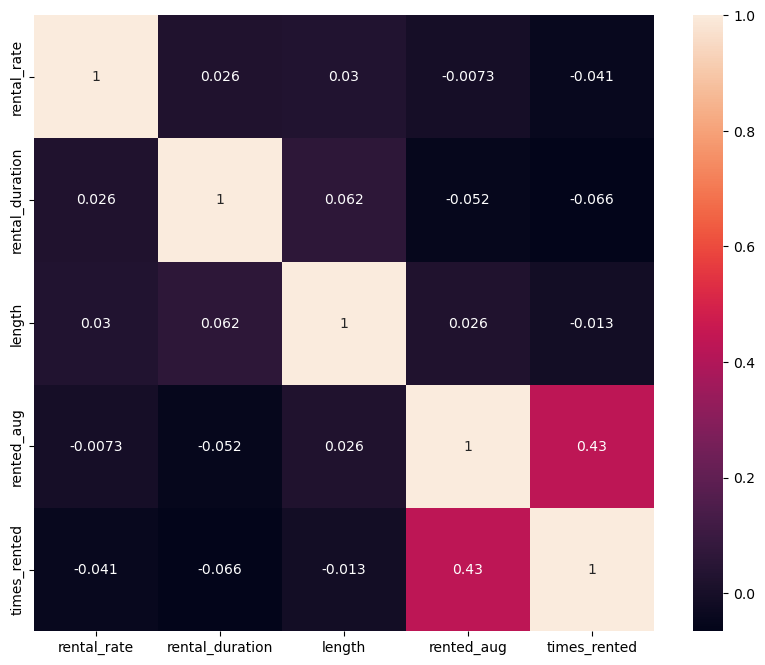

In [23]:
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.
#there is no multicolinearity between the numerical values, so no need to drop
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix=data_cpl.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()


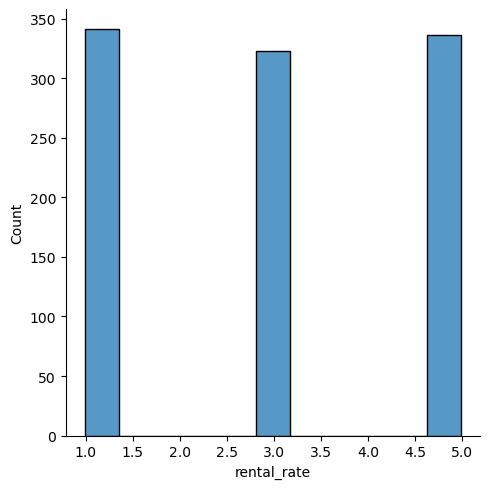

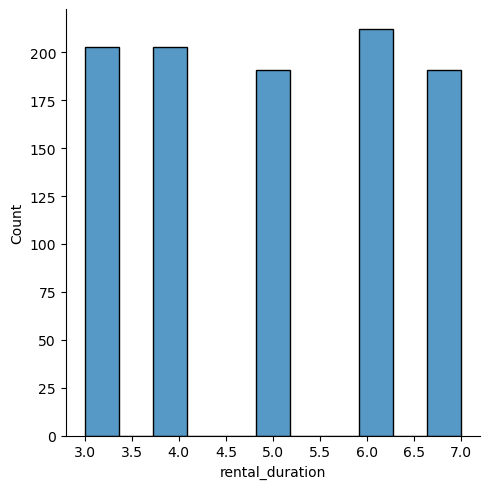

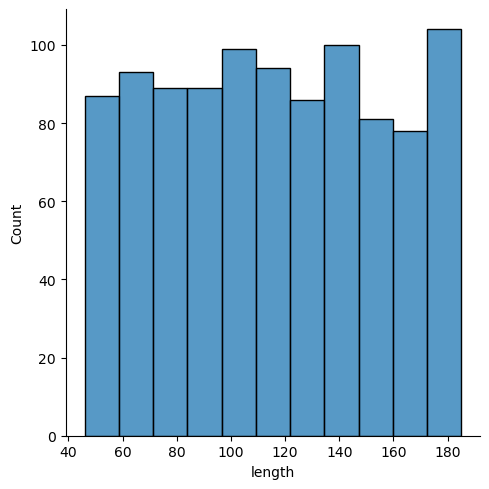

In [24]:
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.
sns.displot(data_no_title['rental_rate'])
plt.show()

sns.displot(data_no_title['rental_duration'])
plt.show()

sns.displot(data_no_title['length'])
plt.show()

In [25]:

#making X-Y split
X = data_no_title.drop(['rented_aug'],axis=1)
y = data_no_title['rented_aug']


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [27]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#cat/num X-train
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(object)

#cat/num X-test
X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = np.object)

#Scale X-train
transformer = StandardScaler().fit(X_train_num)
X_scaled_train = pd.DataFrame(transformer.transform(X_train_num),columns=X_train_num.columns)

#Scale X-test
X_scaled_test = pd.DataFrame(transformer.transform(X_test_num),columns=X_test_num.columns)
X_scaled_test

C:\Users\it-it\AppData\Local\Temp\ipykernel_10284\2347308970.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_cat = X_test.select_dtypes(include = np.object)


,rental_rate,rental_duration,length,times_rented
0,-0.019000,-0.719796,0.544084,-0.968570
1,-1.228093,-1.427460,1.567696,2.246387
2,-1.228093,1.403198,-0.854021,0.460300
3,1.190093,-0.012131,1.043407,-0.254135
4,1.190093,0.695533,-0.329732,1.531953
...,...,...,...,...
295,1.190093,1.403198,-1.727836,-0.611352
296,-0.019000,-1.427460,0.194558,0.103083
297,-1.228093,-1.427460,-0.779122,0.817518
298,1.190093,0.695533,-1.528107,-0.254135


In [28]:
from sklearn.preprocessing import OneHotEncoder
# Onehot encoding
encoder = OneHotEncoder().fit(X_train_cat)

# encode training data
train_encoded = encoder.transform(X_train_cat).toarray()

train_encoded_columns = list()
train_dropped_columns = list()

for columns in encoder.categories_:
    condition = True
    for column in columns.tolist():
        if condition:
            train_dropped_columns.append(column)
            train_encoded_columns.append(column)
            condition = False
        else:
            train_encoded_columns.append(column)

train_cat_encoded = pd.DataFrame(data = train_encoded, columns=train_encoded_columns)
train_cat_encoded = train_cat_encoded.drop(columns = train_dropped_columns)
train_cat_encoded.head()

,NC-17,PG,PG-13,R,Animation,Children,Classics,Comedy,Documentary,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:

# encode test data
test_encoded = encoder.transform(X_test_cat).toarray()

test_encoded_columns = list()
test_dropped_columns = list()

for columns in encoder.categories_:
    condition = True
    for column in columns.tolist():
        if condition:
            test_dropped_columns.append(column)
            test_encoded_columns.append(column)
            condition = False
        else:
            test_encoded_columns.append(column)

test_cat_encoded = pd.DataFrame(data = test_encoded, columns=test_encoded_columns)
test_cat_encoded = test_cat_encoded.drop(columns = test_dropped_columns)
test_cat_encoded

,NC-17,PG,PG-13,R,Animation,Children,Classics,Comedy,Documentary,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
297,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
298,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:

#merging the data and training set with encoded and normalized values and the dropped special_features
# Training data first
X_train_nrml = pd.concat([X_scaled_train,train_cat_encoded], axis = 1)
X_train_nrml


,rental_rate,rental_duration,length,times_rented,NC-17,PG,PG-13,R,Animation,Children,...,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel
0,-0.019000,-1.427460,-1.578039,-0.611352,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.019000,-0.012131,0.244490,-0.968570,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.019000,-1.427460,1.392933,0.460300,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.228093,1.403198,-1.153615,0.103083,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.190093,-0.719796,-1.528107,-1.325787,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-0.019000,-0.719796,-1.303411,-1.325787,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,1.190093,-0.012131,0.818711,0.103083,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,1.190093,-1.427460,-0.105036,-0.254135,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
698,-1.228093,-0.719796,0.169592,0.817518,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
#merging test data
X_test_nrml = pd.concat([X_scaled_test,test_cat_encoded], axis = 1)

In [32]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=10, solver='lbfgs').fit(X_train_nrml, y_train)

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predictions = classification.predict(X_test_nrml)
classification.score(X_test_nrml, y_test)

print("precision: ",precision_score(y_test,predictions))
print("recall: ",recall_score(y_test,predictions))
print("f1: ",f1_score(y_test,predictions))

precision:  1.0
recall:  1.0
f1:  1.0


In [34]:

predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predictions,y_test)

array([[ 10,   0],
       [  0, 290]], dtype=int64)

In [36]:
df_predictions = pd.concat([data_cpl,pd.Series(predictions)],axis=1).head()
df_predictions.head()


,film_title,rental_rate,rental_duration,length,rating,category,rented_aug,times_rented,0
0,ACADEMY DINOSAUR,0.99,6,86,PG,Documentary,1,9,1.0
1,ACE GOLDFINGER,4.99,3,48,G,Horror,1,4,1.0
2,ADAPTATION HOLES,2.99,7,50,NC-17,Documentary,1,6,1.0
3,AFFAIR PREJUDICE,2.99,5,117,G,Horror,1,6,1.0
4,AFRICAN EGG,2.99,6,130,G,Family,1,3,1.0


In [37]:

from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=6, weights='uniform')
clf.fit(X_train_nrml, y_train)
predictions_clf = clf.predict(X_test_nrml)
clf.score(X_test_nrml, y_test)


0.9733333333333334

In [38]:

confusion_matrix(predictions_clf,y_test)


array([[  2,   0],
       [  8, 290]], dtype=int64)

In [39]:


#Using SMOTE to see if we can influence the outcome
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=100,k_neighbors=10)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_nrml,y_train)

In [40]:
class_smote = LogisticRegression(random_state=10,solver='lbfgs').fit(X_train_nrml, y_train)
class_smote.score(X_test_nrml, y_test)

1.0

In [41]:

pred_smote = class_smote.predict(X_test_nrml)

print("precision: ",precision_score(y_test,pred_smote))
print("recall: ",recall_score(y_test,pred_smote))
print("f1: ",f1_score(y_test,pred_smote))

precision:  1.0
recall:  1.0
f1:  1.0


In [42]:
# Either the model is wrong because of the high precision rate or there are movies which are rented in this month or have never ever been rented

In [43]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = ''' SELECT r.rental_id, r.customer_id, f.title, c.name AS category, f.rating, p.amount, r.rental_date, r.return_date
FROM payment AS p
JOIN rental as r
ON r.rental_id = p.rental_id
JOIN inventory AS i
ON r.inventory_id = i.inventory_id
JOIN film AS f
ON f.film_id = i.film_id
JOIN film_category AS fc
ON f.film_id = fc.film_id
JOIN category as c
ON c.category_id = fc.category_id
WHERE r.rental_date BETWEEN ('2005-01-01') AND ('2005-12-31')
GROUP BY f.title'''

data = pd.read_sql_query(query, engine)
data

,rental_id,customer_id,title,category,rating,amount,rental_date,return_date
0,10895,77,AMADEUS HOLY,Action,PG,0.99,2005-08-02 01:16:59,2005-08-03 02:41:59
1,207,47,AMERICAN CIRCUS,Action,R,4.99,2005-05-26 08:04:38,2005-05-27 09:32:38
2,1123,448,ANTITRUST TOMATOES,Action,NC-17,2.99,2005-05-31 16:48:43,2005-06-02 19:17:43
3,3309,463,BAREFOOT MANCHURIAN,Action,G,4.99,2005-06-21 08:00:49,2005-06-29 04:11:49
4,3946,13,BERETS AGENT,Action,PG-13,2.99,2005-07-06 21:39:24,2005-07-11 16:10:24
...,...,...,...,...,...,...,...,...
953,117,7,VALENTINE VANISHING,Travel,PG-13,0.99,2005-05-25 19:30:46,2005-05-31 23:59:46
954,1588,322,WINDOW SIDE,Travel,R,8.99,2005-06-16 04:53:21,2005-06-25 07:29:21
955,3148,202,WOLVES DESIRE,Travel,NC-17,0.99,2005-06-20 20:27:18,2005-06-24 20:30:18
956,9202,466,WORKER TARZAN,Travel,R,3.99,2005-07-30 12:43:24,2005-08-07 10:39:24


In [44]:
query_1 = '''SELECT f.title, COUNT(r.rental_id) AS june_rentals FROM rental AS r
JOIN inventory AS i
ON r.inventory_id = i.inventory_id
JOIN film as f
ON i.film_id = f.film_id
WHERE rental_date BETWEEN '2005-06-01' AND '2005-06-30'
GROUP BY f.title
ORDER BY title ASC'''
data_1 = pd.read_sql_query(query_1, engine)
data_1.head()

,title,june_rentals
0,ACADEMY DINOSAUR,3
1,ADAPTATION HOLES,1
2,AFFAIR PREJUDICE,2
3,AFRICAN EGG,2
4,AGENT TRUMAN,3


In [45]:
query_2 = '''SELECT f.title, COUNT(r.rental_id) AS july_rentals FROM rental AS r
JOIN inventory AS i
ON r.inventory_id = i.inventory_id
JOIN film as f
ON i.film_id = f.film_id
WHERE rental_date BETWEEN '2005-07-01' AND '2005-07-30'
GROUP BY f.title
ORDER BY title ASC'''
data_2 = pd.read_sql_query(query_2, engine)
data_2.head()

,title,july_rentals
0,ACADEMY DINOSAUR,6
1,ACE GOLDFINGER,2
2,ADAPTATION HOLES,4
3,AFFAIR PREJUDICE,9
4,AFRICAN EGG,4


In [46]:
query_3 = '''SELECT COUNT(r.rental_id) AS july_rentals FROM rental AS r
JOIN inventory AS i
ON r.inventory_id = i.inventory_id
JOIN film as f
ON i.film_id = f.film_id
WHERE rental_date BETWEEN '2005-06-01' AND '2005-06-30'
GROUP BY f.title
ORDER BY f.title ASC'''

data['June_rentals'] =  pd.read_sql_query(query_3, engine)
data

,rental_id,customer_id,title,category,rating,amount,rental_date,return_date,June_rentals
0,10895,77,AMADEUS HOLY,Action,PG,0.99,2005-08-02 01:16:59,2005-08-03 02:41:59,3.0
1,207,47,AMERICAN CIRCUS,Action,R,4.99,2005-05-26 08:04:38,2005-05-27 09:32:38,1.0
2,1123,448,ANTITRUST TOMATOES,Action,NC-17,2.99,2005-05-31 16:48:43,2005-06-02 19:17:43,2.0
3,3309,463,BAREFOOT MANCHURIAN,Action,G,4.99,2005-06-21 08:00:49,2005-06-29 04:11:49,2.0
4,3946,13,BERETS AGENT,Action,PG-13,2.99,2005-07-06 21:39:24,2005-07-11 16:10:24,3.0
...,...,...,...,...,...,...,...,...,...
953,117,7,VALENTINE VANISHING,Travel,PG-13,0.99,2005-05-25 19:30:46,2005-05-31 23:59:46,NaN
954,1588,322,WINDOW SIDE,Travel,R,8.99,2005-06-16 04:53:21,2005-06-25 07:29:21,NaN
955,3148,202,WOLVES DESIRE,Travel,NC-17,0.99,2005-06-20 20:27:18,2005-06-24 20:30:18,NaN
956,9202,466,WORKER TARZAN,Travel,R,3.99,2005-07-30 12:43:24,2005-08-07 10:39:24,NaN


In [47]:
query_4 = '''SELECT COUNT(r.rental_id) AS july_rentals FROM rental AS r
JOIN inventory AS i
ON r.inventory_id = i.inventory_id
JOIN film as f
ON i.film_id = f.film_id
WHERE rental_date BETWEEN '2005-07-01' AND '2005-07-31'
GROUP BY f.title
ORDER BY f.title ASC'''

data['July_rentals'] =  pd.read_sql_query(query_4, engine)
data.head()

data = data.fillna(0)
data

,rental_id,customer_id,title,category,rating,amount,rental_date,return_date,June_rentals,July_rentals
0,10895,77,AMADEUS HOLY,Action,PG,0.99,2005-08-02 01:16:59,2005-08-03 02:41:59,3.0,7
1,207,47,AMERICAN CIRCUS,Action,R,4.99,2005-05-26 08:04:38,2005-05-27 09:32:38,1.0,2
2,1123,448,ANTITRUST TOMATOES,Action,NC-17,2.99,2005-05-31 16:48:43,2005-06-02 19:17:43,2.0,4
3,3309,463,BAREFOOT MANCHURIAN,Action,G,4.99,2005-06-21 08:00:49,2005-06-29 04:11:49,2.0,11
4,3946,13,BERETS AGENT,Action,PG-13,2.99,2005-07-06 21:39:24,2005-07-11 16:10:24,3.0,4
...,...,...,...,...,...,...,...,...,...,...
953,117,7,VALENTINE VANISHING,Travel,PG-13,0.99,2005-05-25 19:30:46,2005-05-31 23:59:46,0.0,2
954,1588,322,WINDOW SIDE,Travel,R,8.99,2005-06-16 04:53:21,2005-06-25 07:29:21,0.0,2
955,3148,202,WOLVES DESIRE,Travel,NC-17,0.99,2005-06-20 20:27:18,2005-06-24 20:30:18,0.0,3
956,9202,466,WORKER TARZAN,Travel,R,3.99,2005-07-30 12:43:24,2005-08-07 10:39:24,0.0,6


In [48]:
def yes_no (row):
    if row['June_rentals'] < row['July_rentals']:
        return 'Yes'
    elif row['June_rentals'] > row['July_rentals']:
        return 'No'
    else:
        return 'tie'

    

data['Yes/No'] = data.apply(yes_no, axis=1)
data['Yes/No'].value_counts()

Yes    822
tie     68
No      68
Name: Yes/No, dtype: int64

In [49]:
data['Yes/No'].value_counts()


Yes    822
tie     68
No      68
Name: Yes/No, dtype: int64

In [50]:
sakila = pd.DataFrame(data = data)


In [51]:
sakila


,rental_id,customer_id,title,category,rating,amount,rental_date,return_date,June_rentals,July_rentals,Yes/No
0,10895,77,AMADEUS HOLY,Action,PG,0.99,2005-08-02 01:16:59,2005-08-03 02:41:59,3.0,7,Yes
1,207,47,AMERICAN CIRCUS,Action,R,4.99,2005-05-26 08:04:38,2005-05-27 09:32:38,1.0,2,Yes
2,1123,448,ANTITRUST TOMATOES,Action,NC-17,2.99,2005-05-31 16:48:43,2005-06-02 19:17:43,2.0,4,Yes
3,3309,463,BAREFOOT MANCHURIAN,Action,G,4.99,2005-06-21 08:00:49,2005-06-29 04:11:49,2.0,11,Yes
4,3946,13,BERETS AGENT,Action,PG-13,2.99,2005-07-06 21:39:24,2005-07-11 16:10:24,3.0,4,Yes
...,...,...,...,...,...,...,...,...,...,...,...
953,117,7,VALENTINE VANISHING,Travel,PG-13,0.99,2005-05-25 19:30:46,2005-05-31 23:59:46,0.0,2,Yes
954,1588,322,WINDOW SIDE,Travel,R,8.99,2005-06-16 04:53:21,2005-06-25 07:29:21,0.0,2,Yes
955,3148,202,WOLVES DESIRE,Travel,NC-17,0.99,2005-06-20 20:27:18,2005-06-24 20:30:18,0.0,3,Yes
956,9202,466,WORKER TARZAN,Travel,R,3.99,2005-07-30 12:43:24,2005-08-07 10:39:24,0.0,6,Yes


In [52]:
sakila['rental_id'].value_counts()
sakila['customer_id'].value_counts()
sakila['amount'].value_counts()

4.99     256
2.99     196
0.99     183
3.99      81
5.99      74
6.99      46
7.99      44
8.99      27
1.99      26
9.99      20
10.99      4
11.99      1
Name: amount, dtype: int64

In [53]:

sakila = sakila.drop(['rental_id'], axis = 1)
sakila = sakila.drop(['customer_id'], axis = 1)

In [54]:
sakila.head()

,title,category,rating,amount,rental_date,return_date,June_rentals,July_rentals,Yes/No
0,AMADEUS HOLY,Action,PG,0.99,2005-08-02 01:16:59,2005-08-03 02:41:59,3.0,7,Yes
1,AMERICAN CIRCUS,Action,R,4.99,2005-05-26 08:04:38,2005-05-27 09:32:38,1.0,2,Yes
2,ANTITRUST TOMATOES,Action,NC-17,2.99,2005-05-31 16:48:43,2005-06-02 19:17:43,2.0,4,Yes
3,BAREFOOT MANCHURIAN,Action,G,4.99,2005-06-21 08:00:49,2005-06-29 04:11:49,2.0,11,Yes
4,BERETS AGENT,Action,PG-13,2.99,2005-07-06 21:39:24,2005-07-11 16:10:24,3.0,4,Yes


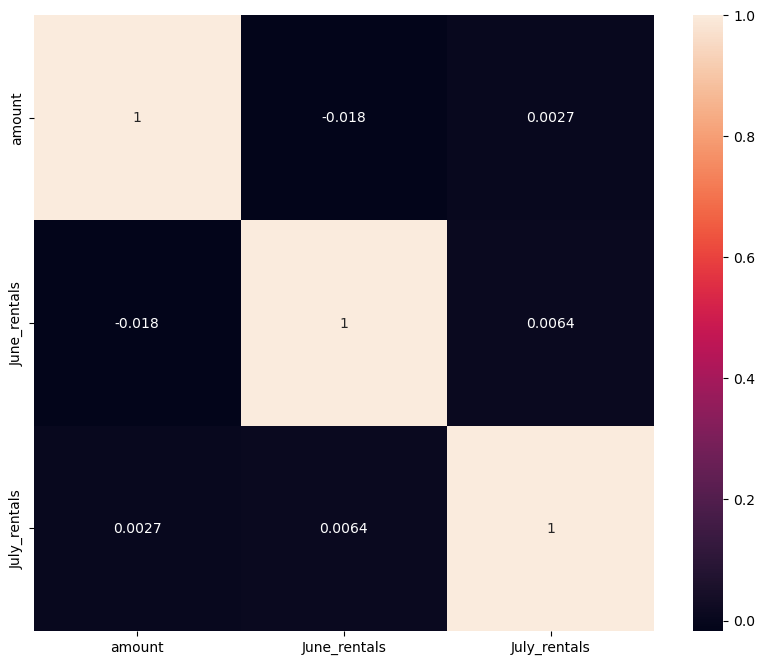

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
corr_matrix=sakila.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [56]:
y = sakila['Yes/No']
X = sakila.drop(['Yes/No'], axis=1)
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [58]:
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

In [59]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
 
X_train_scaled = transformer.fit_transform(X_train_num)
X_train_trans = pd.DataFrame(X_train_scaled, columns = X_train_num.columns)
X_train_trans.head()

,amount,June_rentals,July_rentals
0,0.0,0.285714,0.200000
1,0.3,0.428571,0.400000
2,0.0,0.285714,0.133333
3,0.2,0.571429,0.333333
4,0.0,0.571429,0.466667


In [60]:
X_test_scaled = transformer.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_num.columns)
X_test_scaled

,amount,June_rentals,July_rentals
0,0.0,0.857143,0.266667
1,0.2,0.285714,0.133333
2,0.9,0.428571,0.400000
3,0.8,0.285714,0.266667
4,0.4,0.857143,0.466667
...,...,...,...
187,0.2,0.142857,0.266667
188,0.0,0.142857,0.133333
189,0.4,0.571429,0.800000
190,0.2,0.857143,0.600000


In [ ]:
# This code uses the scikit-learn library to perform one-hot encoding on categorical variables in the training and test datasets.

# "from sklearn.preprocessing import OneHotEncoder" - This line imports the 'OneHotEncoder' class from the 'preprocessing' module of the scikit-learn library.

# "X_train_cat = X_train.select_dtypes(include = object)" - This line creates a new DataFrame 'X_train_cat' that contains only the categorical variables from the training dataset 'X_train'. The 'select_dtypes' method is used to select columns with a data type of 'object'.

# "X_test_cat = X_test.select_dtypes(include = object)" - This line creates a new DataFrame 'X_test_cat' that contains only the categorical variables from the test dataset 'X_test'. The 'select_dtypes' method is used to select columns with a data type of 'object'.

# "encoder = OneHotEncoder(drop='first')" - This line creates an instance of the 'OneHotEncoder' class. The 'drop' parameter is set to 'first', which means that the first level of the categorical variable is dropped to avoid the dummy variable trap.

In [61]:
from sklearn.preprocessing import OneHotEncoder
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat = X_test.select_dtypes(include = object)

encoder = OneHotEncoder(drop='first')
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

In [62]:
encoder.fit(X_train_cat)

OneHotEncoder(drop='first')

In [63]:
X_train_cat_encoded = encoder.transform(X_train_cat).toarray()


In [64]:
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns = encoder.get_feature_names_out())


In [65]:
X_train_cat.value_counts()
# 4 Analyze extracted features and transform them. You may need to encode some categorical variables, 
#or scale numerical variables.

title              category     rating
ACADEMY DINOSAUR   Documentary  PG        1
PAYCHECK WAIT      Drama        PG-13     1
PAPI NECKLACE      Travel       PG        1
PARADISE SABRINA   Comedy       PG-13     1
PARIS WEEKEND      Horror       PG-13     1
                                         ..
FULL FLATLINERS    Children     PG        1
FURY MURDER        Children     PG-13     1
GABLES METROPOLIS  Family       PG        1
GAMES BOWFINGER    Travel       PG-13     1
ZORRO ARK          Comedy       NC-17     1
Length: 766, dtype: int64

In [66]:
X_test_cat.value_counts()


title                   category  rating
ACE GOLDFINGER          Horror    G         1
AFFAIR PREJUDICE        Horror    G         1
PANTHER REDS            Sci-Fi    NC-17     1
PARTY KNOCK             Comedy    PG        1
PEACH INNOCENT          Sports    PG-13     1
                                           ..
GALAXY SWEETHEARTS      Classics  R         1
GILMORE BOILED          Classics  R         1
GLEAMING JAWBREAKER     Sports    NC-17     1
GOLDFINGER SENSIBILITY  Drama     G         1
YOUTH KICK              Music     NC-17     1
Length: 192, dtype: int64

In [67]:
encoder.fit(X_test_cat)


OneHotEncoder(drop='first')

In [68]:
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()


In [69]:
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns = encoder.get_feature_names_out())


In [70]:
display(X_train_cat_encoded.head())
X_test_cat_encoded.head()

,title_ADAPTATION HOLES,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_ALABAMA DEVIL,title_ALLEY EVOLUTION,title_ALONE TRIP,title_ALTER VICTORY,title_AMADEUS HOLY,title_AMELIE HELLFIGHTERS,...,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,title_AFFAIR PREJUDICE,title_AIRPORT POLLOCK,title_ALADDIN CALENDAR,title_ALAMO VIDEOTAPE,title_ALASKA PHANTOM,title_ALI FOREVER,title_ALIEN CENTER,title_ANYTHING SAVANNAH,title_APACHE DIVINE,title_ARTIST COLDBLOODED,...,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [71]:
X_train_treated = np.concatenate([X_train_trans, X_train_cat_encoded], axis=1)
X_train_treated.shape

(766, 787)

In [72]:
X_test_treated = np.concatenate([X_test_scaled, X_test_cat_encoded], axis=1)
X_test_treated.shape

(192, 213)

In [ ]:
# # 5 Create a logistic regression model to predict this variable from the cleaned data.

# This code uses the scikit-learn library to fit a logistic regression model.
# "from sklearn.linear_model import LogisticRegression" - This line imports the 'LogisticRegression' class from the 'linear_model' module of the scikit-learn library.
# "from sklearn.metrics import accuracy_score" - This line imports the 'accuracy_score' function from the 'metrics' module of the scikit-learn library. This function is used to evaluate the accuracy of a model.
# "lr = LogisticRegression(random_state = 100, solver='lbfgs', multi_class='multinomial')" - This line creates an instance of the 'LogisticRegression' class. The parameters passed to the constructor are:
# 'random_state' is set to 100 to ensure reproducibility of results.
# 'solver' is set to 'lbfgs', which stands for Limited-memory BFGS and is a robust solver for small datasets.
# 'multi_class' is set to 'multinomial' to handle multiclass classification problems.
# "lr.fit(X_train_treated, y_train)" - This line fits the logistic regression model to the training data, represented by 'X_train_treated' and 'y_train'. The 'fit' method trains the model on the training data, so it can make predictions on new data.

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state = 100, solver='lbfgs',
                  multi_class='multinomial')
lr.fit(X_train_treated, y_train)

LogisticRegression(multi_class='multinomial', random_state=100)

In [74]:
lr.fit(X_test_treated, y_test)
# 5 Create a logistic regression model to predict this variable from the cleaned data.
# 6 Evaluate the results.

LogisticRegression(multi_class='multinomial', random_state=100)

In [75]:
y_test_pred = lr.predict(X_test_treated)
# 5 Create a logistic regression model to predict this variable from the cleaned data.
# 6 Evaluate the results.

In [76]:
accuracy_score(y_test, y_test_pred)
# 5 Create a logistic regression model to predict this variable from the cleaned data.


0.9427083333333334

In [77]:
# 6 Evaluate the results.
# The accuracy score is good revealing a good prediction model!# 6 Evaluate the results.